<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [183]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV

import nltk
from nltk.stem.porter import PorterStemmer

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

In [184]:
!pip install pyldavis.genism

  Could not find a version that satisfies the requirement pyldavis.genism (from versions: )
No matching distribution found for pyldavis.genism


In [18]:
yelp = pd.read_json('./data/review_sample.json', lines=True)
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [19]:
nlp = spacy.load('en_core_web_lg')
def tokenize(doc):
    doc = [token for token in nlp(doc) if token.is_stop is False and len(token) > 3]
    return doc

In [20]:
yelp['tokens'] = yelp['text'].apply(tokenize)

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [21]:
vectorizer = TfidfVectorizer(min_df=1, stop_words='english')

In [22]:
vectors = vectorizer.fit_transform(yelp['text'])

In [34]:
nn = NearestNeighbors(n_neighbors = 10, algorithm= 'ball_tree')

In [35]:
nn.fit(vectors)

C:\Users\supas\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:217: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=10, p=2, radius=1.0)

In [36]:
nn.kneighbors(vectors[0])

(array([[0.        , 1.28246091, 1.29625505, 1.30062127, 1.30515772,
         1.31123683, 1.31277998, 1.31901052, 1.321382  , 1.33014107]]),
 array([[   0, 2131, 6019, 3276, 8470, 2943, 9036, 2621, 3714, 2207]],
       dtype=int64))

In [37]:
query_string= ["This restaurant sucks! Don't come here ever!!!"]
query_vector = vectorizer.transform(query_string)

In [38]:
nn.kneighbors(query_vector.todense())

(array([[1.06323501, 1.14079392, 1.14193896, 1.19573231, 1.1963352 ,
         1.22307989, 1.24492303, 1.25253679, 1.25665668, 1.25742222]]),
 array([[5423, 3411, 3230, 9035, 5105, 5796, 6167, 5420, 1993, 2720]],
       dtype=int64))

In [41]:
yelp['text'].iloc[[5423, 3411, 3230, 9035, 5105, 5796, 6167, 5420, 1993, 2720]]

5423          New owners took over.  The pizza sucks now!
3411    NO RECOMMENDATION TO THIS PLACE AT ALL!!!! SO ...
3230    This place just sucks. Food was terrible. Serv...
9035    I am very disappointed with this place. Their ...
5105    The quality of service here is great. The admi...
5796    My friend and I had dinner here last night, an...
6167    Buying a car sucks. Buying a car after bankrup...
5420    I like small businesses like this. There price...
1993    Amazing! I decided to come back here after see...
2720    3.5\nTo be honest, I thought the food and drin...
Name: text, dtype: object

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [43]:
features = 'text'
target = 'stars'

In [45]:
X = yelp[features]
y = yelp[target]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8, test_size = .2)

In [56]:
vect=TfidfVectorizer(max_df= .4, stop_words='english')

sgdc = SGDClassifier(early_stopping= True, validation_fraction= .1, max_iter= 500, random_state= 42)

pipeline = Pipeline([
    ('vect',vect),
    ('clf', sgdc)
])

In [57]:
pipeline.fit(X_train, y_train)

C:\Users\supas\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [58]:
pred = pipeline.predict(X_test)

In [62]:
query_prediction = pipeline.predict(query_string)
query_prediction

array([1], dtype=int64)

In [61]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.65      0.80      0.71       297
           2       0.42      0.14      0.21       157
           3       0.34      0.18      0.23       219
           4       0.41      0.37      0.39       419
           5       0.72      0.86      0.78       908

   micro avg       0.62      0.62      0.62      2000
   macro avg       0.51      0.47      0.47      2000
weighted avg       0.58      0.62      0.58      2000



In [54]:
parameters = {
    'vect__max_df': (0.1, 0.2, 0.3, 0.4, 0.5)
}

grid_search = GridSearchCV(pipeline, parameters, cv=5,
                          n_jobs=-1,verbose=1)

grid_search.fit(X_train,y_train)

print('best score:', grid_search.best_score_)
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print((param_name, best_parameters[param_name]))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.9min finished
C:\Users\supas\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


best score: 0.598
Best parameters set:
('vect__max_df', 0.4)


## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [64]:
def preprocess(df, column):
    new_data = []
    for sentence in df[column]:
        tokens = [token.lemma_ for token in nlp(sentence) if token.is_stop is False and len(token) > 3]
        new_data.append(tokens)
    df['processed'] = new_data
    return df

In [66]:
yelp = preprocess(yelp, 'text')

In [223]:
#dictionary = gensim.corpora.Dictionary(yelp['processed'])
#dictionary.filter_extremes(no_below=10, no_above=0.75)
id2word = corpora.Dictionary(yelp['processed'])

In [224]:
#bow_corpus = [dictionary.doc2bow(doc) for doc in yelp['processed']]
corpus = [id2word.doc2bow(text) for text in yelp['processed']]

In [115]:
tfidf = models.TfidfModel(bow_corpus)

corpus_tfidf = tfidf[bow_corpus]

In [226]:
lda_model = gensim.models.LdaMulticore(corpus= corpus, num_topics=5, id2word=id2word)

In [227]:
for idx, topic in lda_model.print_topics():
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.016*"good" + 0.015*"place" + 0.013*"come" + 0.012*"food" + 0.009*"time" + 0.009*"like" + 0.009*"great" + 0.009*"service" + 0.008*"go" + 0.006*"order"
Topic: 1 
Words: 0.012*"great" + 0.011*"good" + 0.010*"go" + 0.009*"place" + 0.008*"time" + 0.007*"come" + 0.007*"food" + 0.007*"order" + 0.006*"look" + 0.005*"tell"
Topic: 2 
Words: 0.016*"good" + 0.012*"food" + 0.010*"great" + 0.009*"service" + 0.008*"time" + 0.008*"place" + 0.008*"like" + 0.007*"friendly" + 0.007*"price" + 0.006*"order"
Topic: 3 
Words: 0.015*"good" + 0.015*"time" + 0.012*"like" + 0.009*"order" + 0.008*"service" + 0.008*"food" + 0.007*"place" + 0.006*"love" + 0.005*"come" + 0.005*"great"
Topic: 4 
Words: 0.015*"food" + 0.015*"place" + 0.013*"order" + 0.010*"great" + 0.008*"come" + 0.008*"good" + 0.008*"like" + 0.006*"service" + 0.006*"work" + 0.005*"restaurant"


In [228]:
clean_topics = [re.findall(r'"([^"]*)"', t[1]) for t in lda_model.print_topics()]

In [229]:
topics = [" ".join(t[0:5]) for t in clean_topics]

In [230]:
distributions = [lda_model[d] for d in bow_corpus]

In [231]:
def update(doc):
        d_dist = {k:0 for k in range(0,5)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distributions = [update(d) for d in distributions]

In [232]:
new_distributions[0]

{0: 0, 1: 0, 2: 0, 3: 0.98048776, 4: 0}

In [233]:
df = pd.DataFrame.from_records(new_distributions)

In [234]:
df.columns = topics
df.index = yelp['review_id']

In [235]:
df.head(50)

,good place come food time,great good go place time,good food great service time,good time like order service,food place order great come
review_id,,,,,
eZs2tpEJtXPwawvHnHZIgQ,0.000000,0.000000,0.000000,0.980488,0.000000
DoQDWJsNbU0KL1O29l_Xug,0.936705,0.015740,0.015974,0.015779,0.015803
DDOdGU7zh56yQHmUnL1idQ,0.817960,0.000000,0.049590,0.127306,0.000000
LfTMUWnfGFMOfOIyJcwLVA,0.956787,0.010850,0.010802,0.010804,0.010757
zJSUdI7bJ8PNJAg4lnl_Gg,0.342140,0.000000,0.641666,0.000000,0.000000
nXYV_0joQEMXYAfNyOPsRw,0.970650,0.000000,0.000000,0.000000,0.000000
ZA7SRi6fTRWwpo-B9O72qQ,0.000000,0.476714,0.000000,0.491470,0.024143
4_GnHPkyTirzK6onIKO4jw,0.010884,0.010766,0.010784,0.956748,0.010819
XGGHc7pYgOm5s6SWr8NMXA,0.922589,0.000000,0.069423,0.000000,0.000000


In [255]:
#cm = CoherenceModel(model= lda_model,texts= yelp['processed'], corpus= bow_corpus, coherence='c_v') 
cm = CoherenceModel(model= lda_model, texts= yelp['processed'], corpus= corpus, coherence='c_v') 

In [256]:
coherence = cm.get_coherence()

In [257]:
coherence

0.3508020090958897

In [242]:
def coherence_values(dictionary, corpus):
    coherence_values = []
    model_list = []
    for topic in range(2,20,2):
        model = gensim.models.LdaMulticore(corpus= corpus, num_topics=topic, id2word=id2word)
        model_list.append(model)
        cm = CoherenceModel(model= model,texts= yelp['processed'], corpus= corpus, coherence='c_v') 
        coherence_values.append(cm.get_coherence())
    return model_list, coherence_values

In [243]:
model_list, coherence_values = coherence_values(dictionary, bow_corpus)

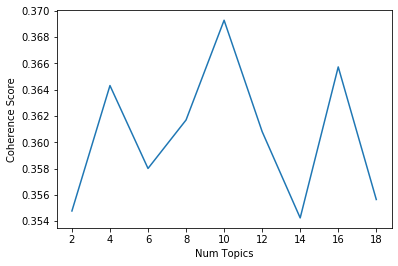

In [244]:
x = range(2, 20, 2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.show()

In [250]:
def coherence_values(dictionary, corpus):
    coherence_values = []
    model_list = []
    for topic in range(5,50,5):
        model = gensim.models.LdaMulticore(corpus= bow_corpus, num_topics=topic, id2word=dictionary)
        model_list.append(model)
        cm = CoherenceModel(model= model,texts= yelp['processed'], corpus= bow_corpus, coherence='c_v') 
        coherence_values.append(cm.get_coherence())
    return model_list, coherence_values

In [251]:
model_list, coherence_values = coherence_values(dictionary, bow_corpus)

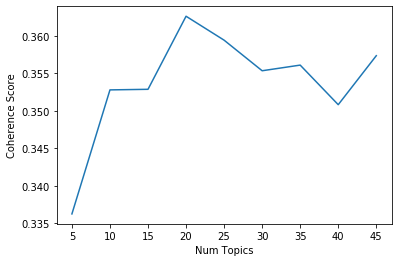

In [252]:
x = range(5, 50, 5)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.show()

# The model benefits from having 20 topics, but drops in coherence with more(only accounting for up to 45 topics). 

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)